<a href="https://colab.research.google.com/github/tolom131/machine-learning-project/blob/master/assignment/11/assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image De-blurring by Supervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log10
from tqdm import tqdm, tqdm_notebook
import random
import os

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

original_train  = data['original_train']
blur_train      = data['blur_train']

original_test   = data['original_test']
blur_test       = data['blur_test']

num_data_train  = original_train.shape[0]
num_data_test   = original_test.shape[0]

print('*************************************************')
print('size of original_train :', original_train.shape)
print('size of blur_train :', blur_train.shape)
print('*************************************************')
print('size of original_test :', original_test.shape)
print('size of blur_test :', blur_test.shape)
print('*************************************************')
print('number of training image :', original_train.shape[0])
print('height of training image :', original_train.shape[1])
print('width of training image :', original_train.shape[2])
print('*************************************************')
print('number of testing image :', original_test.shape[0])
print('height of testing image :', original_test.shape[1])
print('width of testing image :', original_test.shape[2])
print('*************************************************')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
*************************************************
size of original_train : (200, 256, 256)
size of blur_train : (200, 256, 256)
*************************************************
size of original_test : (100, 256, 256)
size of blur_test : (100, 256, 256)
*************************************************
number of training image : 200
height of training image : 256
width of training image : 256
*************************************************
number of testing image : 100
height of testing image : 256
width of testing image : 256
*************************************************


## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 64
learning_rate   = 0.05
weight_decay    = 0.01

## custom data loader for the PyTorch framework

In [4]:
class dataset(Dataset):
    
    def __init__(self, original, blur, transform=False):
        
        self.original   = original
        self.blur       = blur 
        self.transform = transform
    
    def __getitem__(self, index):
        
        original    = self.original[index]
        blur        = self.blur[index]
        
        original    = torch.FloatTensor(original).unsqueeze(dim=0)
        blur        = torch.FloatTensor(blur).unsqueeze(dim=0)

        if self.transform:

            crop_size = [128, 128]
            # random crop
            top         = random.randint(0, original.shape[1] - crop_size[0])
            left        = random.randint(0, original.shape[2] - crop_size[1])
            original    = transforms.functional.crop(original, top, left, crop_size[0], crop_size[1])
            blur        = transforms.functional.crop(blur, top, left, crop_size[0], crop_size[1])
            
            # random horizontal flip
            if random.random() > 0.5: 
                original = transforms.functional.hflip(original)
                blur = transforms.functional.hflip(blur)

            # random vertical flip
            if random.random() > 0.5: 
                original = transforms.functional.vflip(original)
                blur = transforms.functional.vflip(blur)

        return (original, blur)
    
    def __len__(self):
        
        return self.original.shape[0]

## construct datasets and dataloaders for training and testing

In [5]:
dataset_train_transform = dataset(original_train, blur_train, transform=True)
dataset_train           = dataset(original_train, blur_train)
dataset_test            = dataset(original_test, blur_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=1, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=1, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [6]:
(original_train, blur_train)  = dataset_train[0]
(original_test, blur_test)    = dataset_test[0]
(original_train_transform, blur_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the original in the training dataset:', original_train.shape)
print('shape of the blur in the training dataset:', blur_train.shape)
print('*******************************************************************')
print('shape of the original in the testing dataset:', original_test.shape)
print('shape of the blur in the testing dataset:', blur_test.shape)
print('*******************************************************************')
print('shape of the original in the training transform dataset:', original_train_transform.shape)
print('shape of the blur in the training transform dataset:', blur_train_transform.shape)
print('*******************************************************************')

*******************************************************************
shape of the original in the training dataset: torch.Size([1, 256, 256])
shape of the blur in the training dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the testing dataset: torch.Size([1, 256, 256])
shape of the blur in the testing dataset: torch.Size([1, 256, 256])
*******************************************************************
shape of the original in the training transform dataset: torch.Size([1, 128, 128])
shape of the blur in the training transform dataset: torch.Size([1, 128, 128])
*******************************************************************


## class for the neural network 

In [7]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers =  []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

## build network

In [8]:
model       = Unet().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
x = torch.rand(3, 1, 256, 256).to(device)
x = model(x)
x.shape

torch.Size([3, 1, 256, 256])

## compute the prediction

In [10]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #
    prediction = model(input)
    # 
    # ==================================================

    return prediction

## compute the loss

In [11]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    criterion   = nn.MSELoss()
    # 
    # ==================================================
    loss        = criterion(prediction, label)

    return loss

## compute the accuracy

In [12]:
def compute_accuracy(prediction, label):

    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)
    mse_loss    = torch.mean((prediction - label) ** 2)

    if mse_loss == 0.0:
        psnr = 100
    else:
        psnr = 10 * torch.log10(1 / mse_loss)

    psnr = psnr.item()
    
    return psnr

## variables for the learning curve

In [13]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [14]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [15]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (original, blur) in enumerate(dataloader):

        original    = original.to(device)
        blur        = blur.to(device)
        
        prediction  = compute_prediction(model, blur)
        loss        = compute_loss(prediction, original)
        accuracy    = compute_accuracy(prediction, original)

        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [16]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

    print(f"epoch : {i}")
    print(f"\ttrain loss : {loss_train['mean']}, train acc : {accuracy_train['mean']}")
    print(f"\ttest loss  : {loss_test['mean']},  test acc  : {accuracy_test['mean']}")

  1%|          | 1/100 [00:02<04:46,  2.89s/it]

epoch : 0
	train loss : 1.0798398852348328, train acc : 0.5329461892445883
	test loss  : 8.83963875034341e+23,  test acc  : -238.53022171020507


  2%|▏         | 2/100 [00:05<04:43,  2.89s/it]

epoch : 1
	train loss : 0.1281446491678556, train acc : 9.360993226369223
	test loss  : 495565419294228.5,  test acc  : -146.01880783081054


  3%|▎         | 3/100 [00:08<04:40,  2.89s/it]

epoch : 2
	train loss : 0.16366838415463766, train acc : 7.864437421162923
	test loss  : 71730074357.76,  test acc  : -107.95708122253419


  4%|▍         | 4/100 [00:11<04:37,  2.89s/it]

epoch : 3
	train loss : 0.08387555678685506, train acc : 10.87908140818278
	test loss  : 48392620.68,  test acc  : -76.36010055541992


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

epoch : 4
	train loss : 0.03450334072113037, train acc : 14.623994827270508
	test loss  : 163651.35662597656,  test acc  : -51.29399463653564


  6%|▌         | 6/100 [00:17<04:31,  2.89s/it]

epoch : 5
	train loss : 0.03228996631999811, train acc : 15.160703976949057
	test loss  : 4903.882281646728,  test acc  : -35.31801836013794


  7%|▋         | 7/100 [00:20<04:28,  2.89s/it]

epoch : 6
	train loss : 0.03343293940027555, train acc : 14.777616500854492
	test loss  : 238.76514234542847,  test acc  : -21.349701910018922


  8%|▊         | 8/100 [00:23<04:25,  2.89s/it]

epoch : 7
	train loss : 0.027596284324924152, train acc : 15.602532704671225
	test loss  : 70.18930688291788,  test acc  : -14.68529614150524


  9%|▉         | 9/100 [00:25<04:22,  2.89s/it]

epoch : 8
	train loss : 0.02208639184633891, train acc : 16.588972409566242
	test loss  : 4.088670410625636,  test acc  : -1.2949439978599548


 10%|█         | 10/100 [00:28<04:19,  2.89s/it]

epoch : 9
	train loss : 0.01903468184173107, train acc : 17.23670705159505
	test loss  : 2.1828797778952866,  test acc  : 2.8727759408950804


 11%|█         | 11/100 [00:31<04:16,  2.89s/it]

epoch : 10
	train loss : 0.017900823925932247, train acc : 17.47810236612956
	test loss  : 3.5133764971699564,  test acc  : 2.732316185235977


 12%|█▏        | 12/100 [00:34<04:13,  2.88s/it]

epoch : 11
	train loss : 0.016367470535139244, train acc : 17.863104502360027
	test loss  : 3.7780513948760928,  test acc  : 3.5718578690290452


 13%|█▎        | 13/100 [00:37<04:10,  2.88s/it]

epoch : 12
	train loss : 0.0158194483568271, train acc : 18.022334416707356
	test loss  : 0.6556980547681451,  test acc  : 9.41711385846138


 14%|█▍        | 14/100 [00:40<04:07,  2.88s/it]

epoch : 13
	train loss : 0.014182471049328646, train acc : 18.488030115763348
	test loss  : 0.913567470703274,  test acc  : 9.090646296590567


 15%|█▌        | 15/100 [00:43<04:05,  2.88s/it]

epoch : 14
	train loss : 0.014487450631956259, train acc : 18.391680399576824
	test loss  : 0.2350395333673805,  test acc  : 13.179762542322278


 16%|█▌        | 16/100 [00:46<04:02,  2.88s/it]

epoch : 15
	train loss : 0.014236516940097014, train acc : 18.46607844034831
	test loss  : 0.01374119661282748,  test acc  : 19.229857006072997


 17%|█▋        | 17/100 [00:49<03:59,  2.88s/it]

epoch : 16
	train loss : 0.013530628755688667, train acc : 18.697837193806965
	test loss  : 0.049606308010406795,  test acc  : 16.452524063587187


 18%|█▊        | 18/100 [00:51<03:56,  2.89s/it]

epoch : 17
	train loss : 0.014007237429420153, train acc : 18.54914665222168
	test loss  : 0.05408052033279091,  test acc  : 15.852095900774001


 19%|█▉        | 19/100 [00:54<03:53,  2.89s/it]

epoch : 18
	train loss : 0.014038066069285074, train acc : 18.541755040486652
	test loss  : 0.02532950565451756,  test acc  : 18.056901621818543


 20%|██        | 20/100 [00:57<03:50,  2.89s/it]

epoch : 19
	train loss : 0.01345104289551576, train acc : 18.71872075398763
	test loss  : 0.01252954921219498,  test acc  : 19.498916893005372


 21%|██        | 21/100 [01:00<03:47,  2.89s/it]

epoch : 20
	train loss : 0.012395153443018595, train acc : 19.074915568033855
	test loss  : 0.017493238686583937,  test acc  : 18.627440090179444


 22%|██▏       | 22/100 [01:03<03:45,  2.89s/it]

epoch : 21
	train loss : 0.012750741094350815, train acc : 18.952815373738606
	test loss  : 0.023262659749016167,  test acc  : 18.320598044395446


 23%|██▎       | 23/100 [01:06<03:42,  2.88s/it]

epoch : 22
	train loss : 0.013580607250332832, train acc : 18.672753016153973
	test loss  : 0.010505177557934075,  test acc  : 20.367292213439942


 24%|██▍       | 24/100 [01:09<03:39,  2.88s/it]

epoch : 23
	train loss : 0.013715861675639948, train acc : 18.629044850667317
	test loss  : 0.043902512101922184,  test acc  : 17.97145300626755


 25%|██▌       | 25/100 [01:12<03:36,  2.88s/it]

epoch : 24
	train loss : 0.013126924013098082, train acc : 18.834274291992188
	test loss  : 0.01898623102810234,  test acc  : 18.949553813934326


 26%|██▌       | 26/100 [01:15<03:33,  2.89s/it]

epoch : 25
	train loss : 0.012688267976045609, train acc : 18.973702748616535
	test loss  : 0.015170815964229405,  test acc  : 19.459111204147337


 27%|██▋       | 27/100 [01:17<03:30,  2.89s/it]

epoch : 26
	train loss : 0.012237834123273691, train acc : 19.141112009684246
	test loss  : 0.015261982874944806,  test acc  : 19.574427223205568


 28%|██▊       | 28/100 [01:20<03:27,  2.89s/it]

epoch : 27
	train loss : 0.012167753651738167, train acc : 19.154972712198894
	test loss  : 0.013160335500724613,  test acc  : 19.953064279556273


 29%|██▉       | 29/100 [01:23<03:24,  2.89s/it]

epoch : 28
	train loss : 0.013004716485738754, train acc : 18.893078486124676
	test loss  : 0.015312768316362054,  test acc  : 19.743826341629028


 30%|███       | 30/100 [01:26<03:21,  2.88s/it]

epoch : 29
	train loss : 0.013401760098834833, train acc : 18.728891372680664
	test loss  : 0.028749644691124558,  test acc  : 15.920082006454468


 31%|███       | 31/100 [01:29<03:18,  2.88s/it]

epoch : 30
	train loss : 0.014400464482605457, train acc : 18.446462631225586
	test loss  : 0.01898157935589552,  test acc  : 17.69808653831482


 32%|███▏      | 32/100 [01:32<03:16,  2.88s/it]

epoch : 31
	train loss : 0.013770774627725283, train acc : 18.660057703653973
	test loss  : 0.022644052873365583,  test acc  : 17.889649076461794


 33%|███▎      | 33/100 [01:35<03:13,  2.88s/it]

epoch : 32
	train loss : 0.012461580025653044, train acc : 19.046053568522137
	test loss  : 0.01694158663507551,  test acc  : 18.518947143554687


 34%|███▍      | 34/100 [01:38<03:10,  2.88s/it]

epoch : 33
	train loss : 0.012186264619231224, train acc : 19.144287109375
	test loss  : 0.011456133336760104,  test acc  : 20.273947010040285


 35%|███▌      | 35/100 [01:40<03:07,  2.88s/it]

epoch : 34
	train loss : 0.011956491197148958, train acc : 19.231917063395183
	test loss  : 0.011525766891427338,  test acc  : 20.360441370010378


 36%|███▌      | 36/100 [01:43<03:04,  2.88s/it]

epoch : 35
	train loss : 0.012417661026120186, train acc : 19.079118092854817
	test loss  : 0.009289740226231516,  test acc  : 21.069249753952025


 37%|███▋      | 37/100 [01:46<03:01,  2.88s/it]

epoch : 36
	train loss : 0.012024520275493463, train acc : 19.21674919128418
	test loss  : 0.009529203800484538,  test acc  : 20.982662267684937


 38%|███▊      | 38/100 [01:49<02:58,  2.88s/it]

epoch : 37
	train loss : 0.012217020305494467, train acc : 19.1329402923584
	test loss  : 0.009119682007003575,  test acc  : 21.19999436378479


 39%|███▉      | 39/100 [01:52<02:55,  2.88s/it]

epoch : 38
	train loss : 0.012255938102801641, train acc : 19.127601623535156
	test loss  : 0.015310069879051298,  test acc  : 19.747008514404296


 40%|████      | 40/100 [01:55<02:53,  2.89s/it]

epoch : 39
	train loss : 0.013660495169460773, train acc : 18.6697998046875
	test loss  : 0.012039308631792665,  test acc  : 20.243036184310913


 41%|████      | 41/100 [01:58<02:50,  2.88s/it]

epoch : 40
	train loss : 0.013066092506051064, train acc : 18.87028694152832
	test loss  : 0.010394678856246174,  test acc  : 20.65115619659424


 42%|████▏     | 42/100 [02:01<02:47,  2.89s/it]

epoch : 41
	train loss : 0.011994069442152977, train acc : 19.213528951009113
	test loss  : 0.009590910603292287,  test acc  : 20.968920001983644


 43%|████▎     | 43/100 [02:04<02:44,  2.89s/it]

epoch : 42
	train loss : 0.012338158674538136, train acc : 19.09419314066569
	test loss  : 0.014447376825846731,  test acc  : 20.01187491416931


 44%|████▍     | 44/100 [02:06<02:41,  2.88s/it]

epoch : 43
	train loss : 0.012581562623381615, train acc : 19.044034322102863
	test loss  : 0.010161507669836282,  test acc  : 20.819631338119507


 45%|████▌     | 45/100 [02:09<02:38,  2.88s/it]

epoch : 44
	train loss : 0.01204757330318292, train acc : 19.219751993815105
	test loss  : 0.010247261943295598,  test acc  : 20.575923585891722


 46%|████▌     | 46/100 [02:12<02:35,  2.88s/it]

epoch : 45
	train loss : 0.011421858333051205, train acc : 19.424111048380535
	test loss  : 0.012316954683046787,  test acc  : 19.836885986328124


 47%|████▋     | 47/100 [02:15<02:32,  2.88s/it]

epoch : 46
	train loss : 0.011943536810576916, train acc : 19.237831115722656
	test loss  : 0.009857359095476567,  test acc  : 20.84037455558777


 48%|████▊     | 48/100 [02:18<02:30,  2.89s/it]

epoch : 47
	train loss : 0.011839778783420721, train acc : 19.266573588053387
	test loss  : 0.008910620557144285,  test acc  : 21.319839506149293


 49%|████▉     | 49/100 [02:21<02:27,  2.88s/it]

epoch : 48
	train loss : 0.012909957518180212, train acc : 18.899507522583008
	test loss  : 0.008796285239513963,  test acc  : 21.431685361862183


 50%|█████     | 50/100 [02:24<02:24,  2.88s/it]

epoch : 49
	train loss : 0.01240891528626283, train acc : 19.073309580485027
	test loss  : 0.010201851350720971,  test acc  : 20.718366146087646


 51%|█████     | 51/100 [02:27<02:21,  2.88s/it]

epoch : 50
	train loss : 0.013198613499601683, train acc : 18.83212153116862
	test loss  : 0.008978144971188158,  test acc  : 21.259615535736085


 52%|█████▏    | 52/100 [02:30<02:18,  2.88s/it]

epoch : 51
	train loss : 0.01214016197870175, train acc : 19.168963114420574
	test loss  : 0.010792432429734617,  test acc  : 20.61887616157532


 53%|█████▎    | 53/100 [02:32<02:15,  2.88s/it]

epoch : 52
	train loss : 0.012467690743505955, train acc : 19.048137029012043
	test loss  : 0.015285322952549904,  test acc  : 19.840174527168273


 54%|█████▍    | 54/100 [02:35<02:12,  2.88s/it]

epoch : 53
	train loss : 0.011440416177113851, train acc : 19.47198422749837
	test loss  : 0.008997738671023398,  test acc  : 21.27784013748169


 55%|█████▌    | 55/100 [02:38<02:09,  2.88s/it]

epoch : 54
	train loss : 0.011847754009068012, train acc : 19.272915522257488
	test loss  : 0.009475986033212393,  test acc  : 20.978897552490235


 56%|█████▌    | 56/100 [02:41<02:06,  2.88s/it]

epoch : 55
	train loss : 0.011008717430134615, train acc : 19.594881693522137
	test loss  : 0.011901450909208506,  test acc  : 19.683529481887817


 57%|█████▋    | 57/100 [02:44<02:03,  2.88s/it]

epoch : 56
	train loss : 0.012517757092912992, train acc : 19.050661087036133
	test loss  : 0.00968003499088809,  test acc  : 20.80424635887146


 58%|█████▊    | 58/100 [02:47<02:01,  2.88s/it]

epoch : 57
	train loss : 0.012248475415011248, train acc : 19.13806406656901
	test loss  : 0.010283844717778266,  test acc  : 20.614078216552734


 59%|█████▉    | 59/100 [02:50<01:58,  2.89s/it]

epoch : 58
	train loss : 0.012233261639873186, train acc : 19.126521428426106
	test loss  : 0.009253423945046961,  test acc  : 21.086641759872435


 60%|██████    | 60/100 [02:53<01:55,  2.88s/it]

epoch : 59
	train loss : 0.012590665680666765, train acc : 19.003711700439453
	test loss  : 0.01268455915618688,  test acc  : 20.399660539627074


 61%|██████    | 61/100 [02:55<01:52,  2.88s/it]

epoch : 60
	train loss : 0.013653582272430262, train acc : 18.649329503377277
	test loss  : 0.01209018707741052,  test acc  : 19.589878339767456


 62%|██████▏   | 62/100 [02:58<01:49,  2.89s/it]

epoch : 61
	train loss : 0.013112432633837065, train acc : 18.840720494588215
	test loss  : 0.010075495885685086,  test acc  : 20.558664026260377


 63%|██████▎   | 63/100 [03:01<01:46,  2.89s/it]

epoch : 62
	train loss : 0.011178492568433285, train acc : 19.55348777770996
	test loss  : 0.010105136246420444,  test acc  : 20.684645853042603


 64%|██████▍   | 64/100 [03:04<01:43,  2.89s/it]

epoch : 63
	train loss : 0.01215458537141482, train acc : 19.167184829711914
	test loss  : 0.011784706134349107,  test acc  : 19.8010045337677


 65%|██████▌   | 65/100 [03:07<01:40,  2.89s/it]

epoch : 64
	train loss : 0.012290138440827528, train acc : 19.105096181233723
	test loss  : 0.01344946985365823,  test acc  : 19.809922571182252


 66%|██████▌   | 66/100 [03:10<01:38,  2.88s/it]

epoch : 65
	train loss : 0.01251674722880125, train acc : 19.026994069417317
	test loss  : 0.015872026856523006,  test acc  : 19.09082721710205


 67%|██████▋   | 67/100 [03:13<01:35,  2.88s/it]

epoch : 66
	train loss : 0.01226260575155417, train acc : 19.115484873453777
	test loss  : 0.023798901552800088,  test acc  : 18.08412486076355


 68%|██████▊   | 68/100 [03:16<01:32,  2.88s/it]

epoch : 67
	train loss : 0.013096200302243233, train acc : 18.87273406982422
	test loss  : 0.05115414188243449,  test acc  : 14.952329158782959


 69%|██████▉   | 69/100 [03:19<01:29,  2.88s/it]

epoch : 68
	train loss : 0.01278090321769317, train acc : 18.94137446085612
	test loss  : 0.013651192714460194,  test acc  : 20.105619773864746


 70%|███████   | 70/100 [03:21<01:26,  2.88s/it]

epoch : 69
	train loss : 0.011912301803628603, train acc : 19.251375198364258
	test loss  : 0.00971139061381109,  test acc  : 21.057845573425293


 71%|███████   | 71/100 [03:24<01:23,  2.88s/it]

epoch : 70
	train loss : 0.013673476874828339, train acc : 18.66888364156087
	test loss  : 0.013135750517249108,  test acc  : 19.35286745071411


 72%|███████▏  | 72/100 [03:27<01:20,  2.88s/it]

epoch : 71
	train loss : 0.011552878965934118, train acc : 19.377787907918293
	test loss  : 0.01587060083867982,  test acc  : 18.874734258651735


 73%|███████▎  | 73/100 [03:30<01:17,  2.88s/it]

epoch : 72
	train loss : 0.011966359491149584, train acc : 19.22428321838379
	test loss  : 0.01052259782096371,  test acc  : 20.38700922012329


 74%|███████▍  | 74/100 [03:33<01:14,  2.88s/it]

epoch : 73
	train loss : 0.011103222767512003, train acc : 19.55008379618327
	test loss  : 0.008962008706294,  test acc  : 21.29487624168396


 75%|███████▌  | 75/100 [03:36<01:12,  2.88s/it]

epoch : 74
	train loss : 0.012212307192385197, train acc : 19.170292536417644
	test loss  : 0.008610247909091413,  test acc  : 21.48263027191162


 76%|███████▌  | 76/100 [03:39<01:09,  2.88s/it]

epoch : 75
	train loss : 0.01042709220200777, train acc : 19.82176971435547
	test loss  : 0.010546565849799662,  test acc  : 20.465013542175292


 77%|███████▋  | 77/100 [03:42<01:06,  2.88s/it]

epoch : 76
	train loss : 0.010949766884247461, train acc : 19.629034678141277
	test loss  : 0.009364859079942106,  test acc  : 21.004059352874755


 78%|███████▊  | 78/100 [03:44<01:03,  2.88s/it]

epoch : 77
	train loss : 0.011849250023563703, train acc : 19.281470616658527
	test loss  : 0.016101551675237715,  test acc  : 18.32125774383545


 79%|███████▉  | 79/100 [03:47<01:00,  2.88s/it]

epoch : 78
	train loss : 0.011909669575591883, train acc : 19.257383346557617
	test loss  : 0.014186651185154915,  test acc  : 18.948312635421754


 80%|████████  | 80/100 [03:50<00:57,  2.89s/it]

epoch : 79
	train loss : 0.011906477312246958, train acc : 19.260746002197266
	test loss  : 0.00900689567439258,  test acc  : 21.26303822517395


 81%|████████  | 81/100 [03:53<00:54,  2.88s/it]

epoch : 80
	train loss : 0.011273303379615148, train acc : 19.483157475789387
	test loss  : 0.010531776712741702,  test acc  : 20.556558895111085


 82%|████████▏ | 82/100 [03:56<00:51,  2.88s/it]

epoch : 81
	train loss : 0.011082798863450686, train acc : 19.555500030517578
	test loss  : 0.009242589364293962,  test acc  : 21.167102069854735


 83%|████████▎ | 83/100 [03:59<00:49,  2.88s/it]

epoch : 82
	train loss : 0.011430783507724604, train acc : 19.427525838216145
	test loss  : 0.009727286440320313,  test acc  : 21.129829120635986


 84%|████████▍ | 84/100 [04:02<00:46,  2.88s/it]

epoch : 83
	train loss : 0.0125323918958505, train acc : 19.023945490519207
	test loss  : 0.019824996809475123,  test acc  : 19.351480302810668


 85%|████████▌ | 85/100 [04:05<00:43,  2.88s/it]

epoch : 84
	train loss : 0.014338567232092222, train acc : 18.547739664713543
	test loss  : 0.008462583355139941,  test acc  : 21.60596152305603


 86%|████████▌ | 86/100 [04:08<00:40,  2.88s/it]

epoch : 85
	train loss : 0.01167213482161363, train acc : 19.336039861043293
	test loss  : 0.016174211790785195,  test acc  : 19.994571976661682


 87%|████████▋ | 87/100 [04:10<00:37,  2.88s/it]

epoch : 86
	train loss : 0.012052880600094795, train acc : 19.30500666300456
	test loss  : 0.008685401773545891,  test acc  : 21.477850074768067


 88%|████████▊ | 88/100 [04:13<00:34,  2.88s/it]

epoch : 87
	train loss : 0.01098308339715004, train acc : 19.597239812215168
	test loss  : 0.00817932931240648,  test acc  : 21.8282723903656


 89%|████████▉ | 89/100 [04:16<00:31,  2.88s/it]

epoch : 88
	train loss : 0.012581529095768929, train acc : 19.016329447428387
	test loss  : 0.01067084685433656,  test acc  : 20.905178785324097


 90%|█████████ | 90/100 [04:19<00:28,  2.88s/it]

epoch : 89
	train loss : 0.012488645501434803, train acc : 19.038028717041016
	test loss  : 0.011899652667343616,  test acc  : 20.705214004516602


 91%|█████████ | 91/100 [04:22<00:25,  2.88s/it]

epoch : 90
	train loss : 0.013775621230403582, train acc : 18.66955057779948
	test loss  : 0.009205872360616922,  test acc  : 21.105025787353515


 92%|█████████▏| 92/100 [04:25<00:23,  2.89s/it]

epoch : 91
	train loss : 0.012483620395263037, train acc : 19.109058380126953
	test loss  : 0.010067126848734915,  test acc  : 20.824031114578247


 93%|█████████▎| 93/100 [04:28<00:20,  2.88s/it]

epoch : 92
	train loss : 0.012487076533337435, train acc : 19.041343688964844
	test loss  : 0.008284088321961463,  test acc  : 21.712780570983888


 94%|█████████▍| 94/100 [04:31<00:17,  2.88s/it]

epoch : 93
	train loss : 0.01271331620713075, train acc : 18.986997604370117
	test loss  : 0.011768882307223975,  test acc  : 20.53921675682068


 95%|█████████▌| 95/100 [04:34<00:14,  2.88s/it]

epoch : 94
	train loss : 0.01265363364169995, train acc : 19.004575729370117
	test loss  : 0.014558462407439948,  test acc  : 20.10579608917236


 96%|█████████▌| 96/100 [04:36<00:11,  2.88s/it]

epoch : 95
	train loss : 0.012939535081386566, train acc : 18.887088775634766
	test loss  : 0.011215624182950705,  test acc  : 20.51627203941345


 97%|█████████▋| 97/100 [04:39<00:08,  2.88s/it]

epoch : 96
	train loss : 0.012405508508284887, train acc : 19.096147537231445
	test loss  : 0.00844826249871403,  test acc  : 21.655084342956542


 98%|█████████▊| 98/100 [04:42<00:05,  2.88s/it]

epoch : 97
	train loss : 0.01106979139149189, train acc : 19.56710942586263
	test loss  : 0.00963409589836374,  test acc  : 20.952186546325684


 99%|█████████▉| 99/100 [04:45<00:02,  2.88s/it]

epoch : 98
	train loss : 0.011495017446577549, train acc : 19.438289006551106
	test loss  : 0.015625124857760967,  test acc  : 19.849752178192137


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]

epoch : 99
	train loss : 0.011232297246654829, train acc : 19.51954460144043
	test loss  : 0.011288585136644541,  test acc  : 20.620462188720705


---

# functions for visualizing the results 

---

## plot curve

In [17]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [18]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [19]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [20]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [21]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [22]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [23]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [24]:
def function_result_01():

    print('[plot examples of the training original images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_train, _   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [25]:
def function_result_02():

    print('[plot examples of the training blur images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_train   = dataset_train[index_data]
    data_train      = data_train[0]
    
    plot_data_grid(data_train, index_data, nRow, nCol)

In [26]:
def function_result_03():

    print('[plot examples of the training de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    _, data_train       = dataset_train[index_data] 
    data_train          = data_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, data_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [27]:
def function_result_04():

    print('[plot examples of the testing original images]')
    print('') 
    
    nRow = 8 
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    data_test, _    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [28]:
def function_result_05():

    print('[plot examples of the testing blur images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0]
    
    plot_data_grid(data_test, index_data, nRow, nCol)

In [29]:
def function_result_06():

    print('[plot examples of the testing de-blurring results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    _, data_test    = dataset_test[index_data]
    data_test       = data_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, data_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [30]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [31]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [32]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [33]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [34]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [35]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [36]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [39]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training original images]



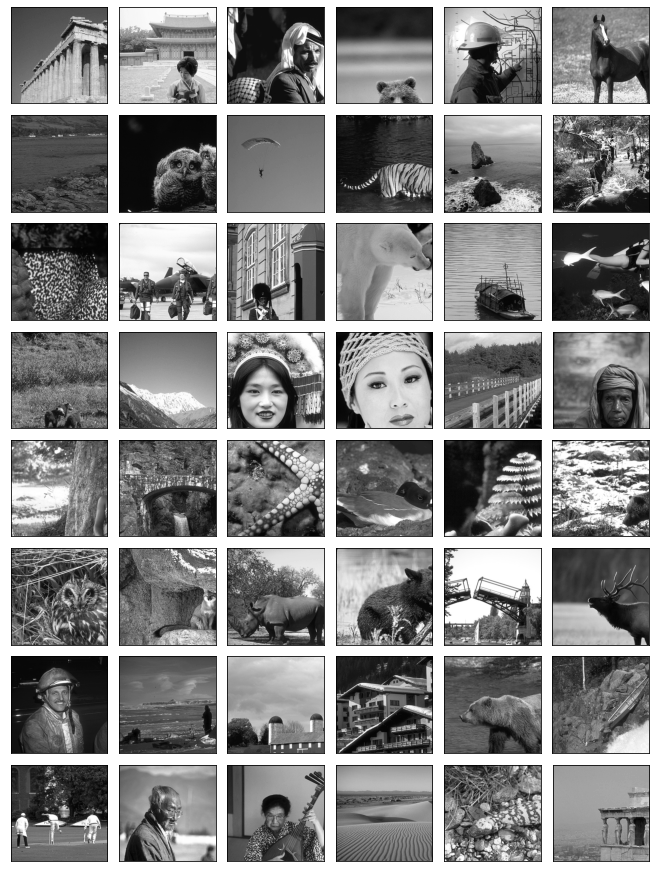


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training blur images]



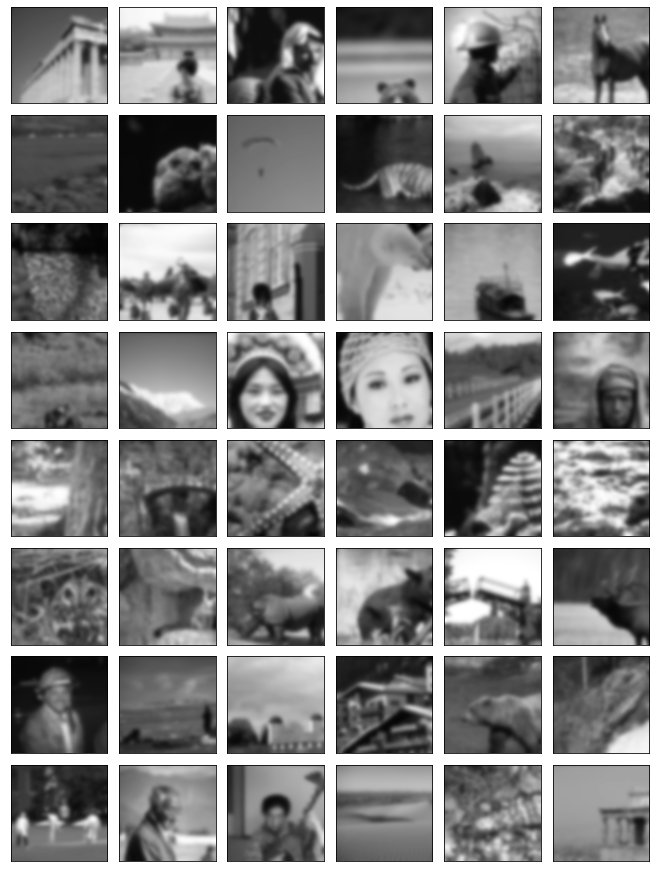


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training de-blurring results]



RuntimeError: ignored

In [40]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)